In [30]:
import numpy as np  # Импортируем библиотеку для работы с массивами и математическими функциями
import pandas as pd  # Импортируем библиотеку для работы с табличными данными
from gensim.models import Word2Vec  # Импортируем класс Word2Vec для обучения модели векторных представлений слов
from sklearn.feature_extraction.text import TfidfVectorizer  # Импортируем класс для работы с TF-IDF векторизацией
import pickle  # Импортируем модуль для сериализации объектов
import pymorphy2  # Импортируем библиотеку для морфологического анализа русского языка
from sklearn.metrics.pairwise import cosine_similarity  # Импортируем функцию для вычисления косинусного сходства

# Инициализация морфологического анализатора для русского языка
morph = pymorphy2.MorphAnalyzer()

# Загрузка данных из CSV файла с 50 внешними рецептами
external_df = pd.read_csv('recipes_50.csv')

# Загрузка данных из вашего основного датасета
df = pd.read_csv('all_recipes_updated.csv')

# Функция для предобработки текста
def preprocess(text):
    text = text.lower()  # Приводим текст к нижнему регистру
    words = text.split()  # Разбиваем текст на слова
    # Лемматизируем слова и соединяем их обратно в строку
    return ' '.join([morph.parse(word)[0].normal_form for word in words])

# Подготовка данных
df['processed'] = df['LIST_INGRID_LEM'].apply(preprocess)  # Применяем предобработку к столбцу ингредиентов в основном датасете
external_df['processed'] = external_df['INGREDIENTS'].apply(preprocess)  # Применяем предобработку к столбцу ингредиентов во внешнем датасете

# Загрузка предобученной модели TF-IDF
with open('tfidf_model.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)  # Загружаем обученную модель TF-IDF из файла

# Функция для получения топ-N рекомендаций с использованием TF-IDF
def get_top_n_tfidf(query_recipes, data_df, vectorizer, n=10):
    X = vectorizer.transform(data_df['processed'])  # Преобразуем тексты в TF-IDF вектора
    
    recommendations = {}
    # Итерируемся по каждому рецепту в запросе
    for idx, row in query_recipes.iterrows():
        vector = vectorizer.transform([row['processed']])  # Преобразуем запрос в TF-IDF вектор
        similarities = cosine_similarity(vector, X)[0]  # Вычисляем косинусное сходство между запросом и данными
        similar_indices = similarities.argsort()[-n:][::-1]  # Получаем индексы N наиболее похожих рецептов
        recommendations[row['NAME']] = {
            'query_ingredients': row['INGREDIENTS'],  # Ингредиенты запроса
            'recommendations': data_df.iloc[similar_indices][['NAME', 'INGREDIENTS']].to_dict('records'),  # Рекомендации
            'scores': similarities[similar_indices]  # Оценки схожести
        }
    
    return recommendations

# Загрузка предобученной модели Word2Vec
word2vec_model = Word2Vec.load("recipes_word2vec.model")

# Функция для получения топ-N рекомендаций с использованием Word2Vec
def get_top_n_word2vec(query_recipes, data_df, model, n=10):
    def vectorize(text):
        words = text.split()  # Разбиваем текст на слова
        vectors = [model.wv[word] for word in words if word in model.wv]  # Получаем векторы слов
        # Вычисляем средний вектор
        return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

    X = np.array([vectorize(text) for text in data_df['processed']])  # Преобразуем данные в векторы
    
    recommendations = {}
    # Итерируемся по каждому рецепту в запросе
    for idx, row in query_recipes.iterrows():
        vector = vectorize(row['processed'])  # Преобразуем запрос в вектор
        if not np.any(vector):  # Проверка на нулевой вектор
            print(f"No valid vectors for query recipe: {row['NAME']}")
            continue
        similarities = cosine_similarity([vector], X)[0]  # Вычисляем косинусное сходство между запросом и данными
        similar_indices = similarities.argsort()[-n:][::-1]  # Получаем индексы N наиболее похожих рецептов
        recommendations[row['NAME']] = {
            'query_ingredients': row['INGREDIENTS'],  # Ингредиенты запроса
            'recommendations': data_df.iloc[similar_indices][['NAME', 'INGREDIENTS']].to_dict('records'),  # Рекомендации
            'scores': similarities[similar_indices]  # Оценки схожести
        }
    
    return recommendations

# Получение топ-10 рекомендаций для TF-IDF и Word2Vec моделей
tfidf_recommendations = get_top_n_tfidf(external_df, df, tfidf_vectorizer)
word2vec_recommendations = get_top_n_word2vec(external_df, df, word2vec_model)

# Функция для создания таблицы для аннотаторов
def create_annotation_table(tfidf_recs, w2v_recs):
    rows = []
    # Итерируемся по рекомендациям TF-IDF
    for query_name, data in tfidf_recs.items():
        query_ingredients = data['query_ingredients']
        for i, (rec, score) in enumerate(zip(data['recommendations'], data['scores'])):
            rows.append([query_name, query_ingredients, "TF-IDF", i+1, rec['NAME'], rec['INGREDIENTS'], score])
    
    # Итерируемся по рекомендациям Word2Vec
    for query_name, data in w2v_recs.items():
        query_ingredients = data['query_ingredients']
        for i, (rec, score) in enumerate(zip(data['recommendations'], data['scores'])):
            rows.append([query_name, query_ingredients, "Word2Vec", i+1, rec['NAME'], rec['INGREDIENTS'], score])
    
    # Создаем DataFrame для аннотаторов
    df_annotations = pd.DataFrame(rows, columns=["Query Recipe", "Query Ingredients", "Model", "Rank", "Recommended Recipe", "Recommended Ingredients", "Score"])
    return df_annotations

# Создание таблицы для аннотаторов
df_annotations = create_annotation_table(tfidf_recommendations, word2vec_recommendations)

# Сохранение таблицы в CSV файл
df_annotations.to_csv('recipe_recommendations_for_annotation.csv', index=False)
print("Annotation table saved to 'recipe_recommendations_for_annotation.csv'")

# Функция для отображения рекомендаций
def display_recommendations(recommendations, model_name):
    print(f"Top-10 Recommendations using {model_name}:")
    for query_name, data in recommendations.items():
        print(f"\nQuery Recipe: {query_name}")
        print(f"Query Ingredients: {data['query_ingredients']}")
        for i, (rec, score) in enumerate(zip(data['recommendations'], data['scores'])):
            print(f"  {i+1}. {rec['NAME']} - Ingredients: {rec['INGREDIENTS']} - Score: {score:.4f}")

# Отображение рекомендаций для TF-IDF и Word2Vec моделей
display_recommendations(tfidf_recommendations, "TF-IDF")
display_recommendations(word2vec_recommendations, "Word2Vec")


Annotation table saved to 'recipe_recommendations_for_annotation.csv'
Top-10 Recommendations using TF-IDF:

Query Recipe: Вино из одуванчиков
Query Ingredients: лимон, сахар, изюм, вода, мята, одуванчик
  1. Варенье из одуванчиков и лимона - Ingredients: Цветы одуванчика 100 г Лимон по вкусу Сахар 6 столовых ложек Свежая мята по вкусу  - Score: 0.5818
  2. Напиток из одуванчиков - Ingredients: Листья одуванчика 20 штук Яблоко 2 штуки Стебель сельдерея 5 штук  - Score: 0.5489
  3. Домашний лимонад из лимона - Ingredients: Лимон 1 штука Вода 2 л Сахар 200 г  - Score: 0.4473
  4. Салат из одуванчиков - Ingredients: Листья одуванчика 700 г Кедровые орехи 3 столовые ложки Оливковое масло 50 мл Чеснок 2 зубчика Соль по вкусу Бальзамический уксус 2 столовые ложки Молотый белый перец по вкусу  - Score: 0.4359
  5. Песто из одуванчиков - Ingredients: Листья одуванчика 350 г Оливковое масло extra virgin 250 мл Чеснок 4 зубчика Кедровые орехи 40 г Морская соль 1,5 чайные ложки Тертый сыр пармезан

In [5]:
import numpy as np  # Импортируем библиотеку для работы с массивами и математическими функциями
import pandas as pd  # Импортируем библиотеку для работы с табличными данными

# Загрузка данных из CSV файла
df = pd.read_csv('annotation_relevance.csv')

# Функция для замены запятой на точку
def replace_comma(value):
    if isinstance(value, str):
        return value.replace(',', '.')  # Если значение строка, заменяем запятую на точку
    return value  # Возвращаем значение без изменений, если оно не строка

# Применение функции к колонкам
df['predicted_relevance_tfidf'] = df['predicted_relevance_tfidf'].apply(replace_comma).astype(float)
df['relevance_tfidf'] = df['relevance_tfidf'].apply(replace_comma).astype(float)
df['predicted_relevance_word2vec'] = df['predicted_relevance_word2vec'].apply(replace_comma).astype(float)
df['relevance_word2vec'] = df['relevance_word2vec'].apply(replace_comma).astype(float)

# Преобразование оценок в формат для вычисления метрик для модели Word2Vec
all_relevant_items_word2vec = []  # Создаем пустой список для хранения релевантных элементов
grouped_word2vec = df.groupby('Query Recipe')['relevance_word2vec'].apply(list)  # Группируем по столбцу 'Query Recipe'
for scores in grouped_word2vec:
    relevant_items = [1 if score > 0 else 0 for score in scores]  # Преобразуем оценки в 1 или 0
    all_relevant_items_word2vec.append(relevant_items)  # Добавляем список релевантных элементов в общий список

# Преобразование оценок в формат для вычисления метрик для модели TF-IDF
all_relevant_items_tfidf = []  # Создаем пустой список для хранения релевантных элементов
grouped_tfidf = df.groupby('Query Recipe')['relevance_tfidf'].apply(list)  # Группируем по столбцу 'Query Recipe'
for scores in grouped_tfidf:
    relevant_items = [1 if score > 0 else 0 for score in scores]  # Преобразуем оценки в 1 или 0
    all_relevant_items_tfidf.append(relevant_items)  # Добавляем список релевантных элементов в общий список

def precision_at_k(relevant_items, k):
    """Вычисляет precision@k."""
    return sum(relevant_items[:k]) / k  # Делим количество релевантных элементов на k

def average_precision_at_k(relevant_items, k=10):
    """Вычисляет AP@K."""
    relevant_items = relevant_items[:k]  # Берем первые k элементов
    precisions = [precision_at_k(relevant_items, i + 1) for i in range(len(relevant_items)) if relevant_items[i]]
    if not precisions:
        return 0.0  # Возвращаем 0.0, если нет точных значений
    return sum(precisions) / len(relevant_items)  # Возвращаем среднее значение precision

def mean_average_precision_at_k(all_relevant_items, k=10):
    """Вычисляет MAP@K для всех запросов."""
    apks = [average_precision_at_k(relevant_items, k) for relevant_items in all_relevant_items]
    return np.mean(apks)  # Возвращаем среднее значение AP@K

def recall_at_k(relevant_items, total_relevant_items, k):
    """Вычисляет recall@k."""
    relevant_at_k = sum(relevant_items[:k])  # Количество релевантных элементов в первых k
    total_relevant = sum(total_relevant_items)  # Общее количество релевантных элементов
    return relevant_at_k / total_relevant if total_relevant > 0 else 0  # Возвращаем долю релевантных элементов

def mean_recall_at_k(all_relevant_items, k=10):
    """Вычисляет средний recall@k для всех запросов."""
    recalls = [recall_at_k(relevant_items, relevant_items, k) for relevant_items in all_relevant_items]
    return np.mean(recalls)  # Возвращаем среднее значение recall

def dcg_at_k(relevant_items, k):
    """Вычисляет DCG@k."""
    relevant_items = np.asfarray(relevant_items)[:k]
    if relevant_items.size:
        return np.sum(relevant_items / np.log2(np.arange(2, relevant_items.size + 2)))  # Вычисляем DCG
    return 0.0  # Возвращаем 0.0, если нет релевантных элементов

def ndcg_at_k(relevant_items, k):
    """Вычисляет NDCG@k."""
    dcg_max = dcg_at_k(sorted(relevant_items, reverse=True), k)  # Вычисляем максимальное значение DCG
    if not dcg_max:
        return 0.0  # Возвращаем 0.0, если нет максимального DCG
    return dcg_at_k(relevant_items, k) / dcg_max  # Возвращаем нормализованное значение DCG

def mean_ndcg_at_k(all_relevant_items, k=10):
    """Вычисляет средний NDCG@k для всех запросов."""
    ndcgs = [ndcg_at_k(relevant_items, k) for relevant_items in all_relevant_items]
    return np.mean(ndcgs)  # Возвращаем среднее значение NDCG

def f1_score_at_k(precision, recall):
    """Вычисляет F1-Score на основе precision и recall."""
    if precision + recall == 0:
        return 0.0  # Возвращаем 0.0, если сумма precision и recall равна 0
    return 2 * (precision * recall) / (precision + recall)  # Вычисляем F1-Score

def mean_f1_score_at_k(all_relevant_items, k=10):
    """Вычисляет средний F1-Score@k для всех запросов."""
    f1_scores = []
    for relevant_items in all_relevant_items:
        precision = precision_at_k(relevant_items, k)
        recall = recall_at_k(relevant_items, relevant_items, k)
        f1_scores.append(f1_score_at_k(precision, recall))
    return np.mean(f1_scores)  # Возвращаем среднее значение F1-Score

# Вычисление MAP@10 для модели Word2Vec
mapk_word2vec = mean_average_precision_at_k(all_relevant_items_word2vec, k=10)
print(f"MAP@10 for Word2Vec: {mapk_word2vec:.4f}")

# Вычисление MAP@10 для модели TF-IDF
mapk_tfidf = mean_average_precision_at_k(all_relevant_items_tfidf, k=10)
print(f"MAP@10 for TF-IDF: {mapk_tfidf:.4f}")

# Вычисление Recall@10 для модели Word2Vec
recall_word2vec = mean_recall_at_k(all_relevant_items_word2vec, k=10)
print(f"Recall@10 for Word2Vec: {recall_word2vec:.4f}")

# Вычисление Recall@10 для модели TF-IDF
recall_tfidf = mean_recall_at_k(all_relevant_items_tfidf, k=10)
print(f"Recall@10 for TF-IDF: {recall_tfidf:.4f}")

# Вычисление NDCG@10 для модели Word2Vec
ndcg_word2vec = mean_ndcg_at_k(all_relevant_items_word2vec, k=10)
print(f"NDCG@10 for Word2Vec: {ndcg_word2vec:.4f}")

# Вычисление NDCG@10 для модели TF-IDF
ndcg_tfidf = mean_ndcg_at_k(all_relevant_items_tfidf, k=10)
print(f"NDCG@10 for TF-IDF: {ndcg_tfidf:.4f}")

# Вычисление F1-Score@10 для модели Word2Vec
f1_word2vec = mean_f1_score_at_k(all_relevant_items_word2vec, k=10)
print(f"F1-Score@10 for Word2Vec: {f1_word2vec:.4f}")

# Вычисление F1-Score@10 для модели TF-IDF
f1_tfidf = mean_f1_score_at_k(all_relevant_items_tfidf, k=10)
print(f"F1-Score@10 for TF-IDF: {f1_tfidf:.4f}")

# Вычисление Precision@10 для модели Word2Vec
precision_word2vec = np.mean([precision_at_k(relevant_items, k=10) for relevant_items in all_relevant_items_word2vec])
print(f"Precision@10 for Word2Vec: {precision_word2vec:.4f}")

# Вычисление Precision@10 для модели TF-IDF
precision_tfidf = np.mean([precision_at_k(relevant_items, k=10) for relevant_items in all_relevant_items_tfidf])
print(f"Precision@10 for TF-IDF: {precision_tfidf:.4f}")

# Вычисление DCG@10 для модели Word2Vec
dcg_word2vec = np.mean([dcg_at_k(relevant_items, k=10) for relevant_items in all_relevant_items_word2vec])
print(f"DCG@10 for Word2Vec: {dcg_word2vec:.4f}")

# Вычисление DCG@10 для модели TF-IDF
dcg_tfidf = np.mean([dcg_at_k(relevant_items, k=10) for relevant_items in all_relevant_items_tfidf])
print(f"DCG@10 for TF-IDF: {dcg_tfidf:.4f}")


MAP@10 for Word2Vec: 0.2397
MAP@10 for TF-IDF: 0.7690
Recall@10 for Word2Vec: 0.8600
Recall@10 for TF-IDF: 0.9800
NDCG@10 for Word2Vec: 0.6133
NDCG@10 for TF-IDF: 0.9279
F1-Score@10 for Word2Vec: 0.4255
F1-Score@10 for TF-IDF: 0.8697
Precision@10 for Word2Vec: 0.3200
Precision@10 for TF-IDF: 0.8140
DCG@10 for Word2Vec: 1.5899
DCG@10 for TF-IDF: 3.7835


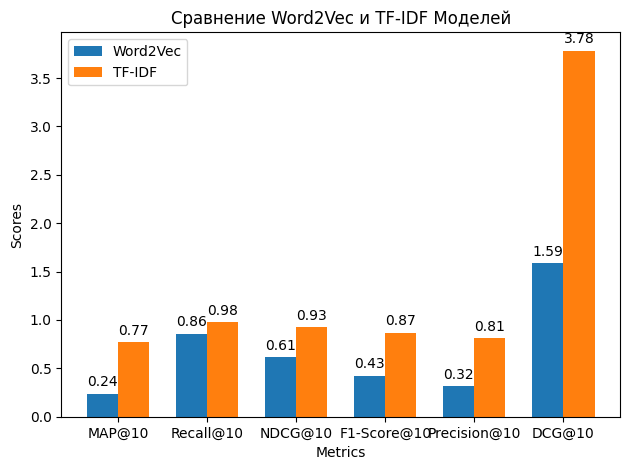

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Метрики для модели Word2Vec
metrics_word2vec = {
    'MAP@10': mapk_word2vec,
    'Recall@10': recall_word2vec,
    'NDCG@10': ndcg_word2vec,
    'F1-Score@10': f1_word2vec,
    'Precision@10': precision_word2vec,
    'DCG@10': dcg_word2vec
}

# Метрики для модели TF-IDF
metrics_tfidf = {
    'MAP@10': mapk_tfidf,
    'Recall@10': recall_tfidf,
    'NDCG@10': ndcg_tfidf,
    'F1-Score@10': f1_tfidf,
    'Precision@10': precision_tfidf,
    'DCG@10': dcg_tfidf
}

# Настройка данных для графика
labels = list(metrics_word2vec.keys())
word2vec_scores = list(metrics_word2vec.values())
tfidf_scores = list(metrics_tfidf.values())

x = np.arange(len(labels))  # Позиции меток на оси x
width = 0.35  # Ширина столбцов

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, word2vec_scores, width, label='Word2Vec')
rects2 = ax.bar(x + width/2, tfidf_scores, width, label='TF-IDF')

# Добавление подписей на столбцы
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Сравнение Word2Vec и TF-IDF Моделей')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Функция для добавления значений на столбцы
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


Уникальные значения для TF-IDF: [1.  0.  0.5]
Уникальные значения для Word2Vec: [0.  0.5 1. ]


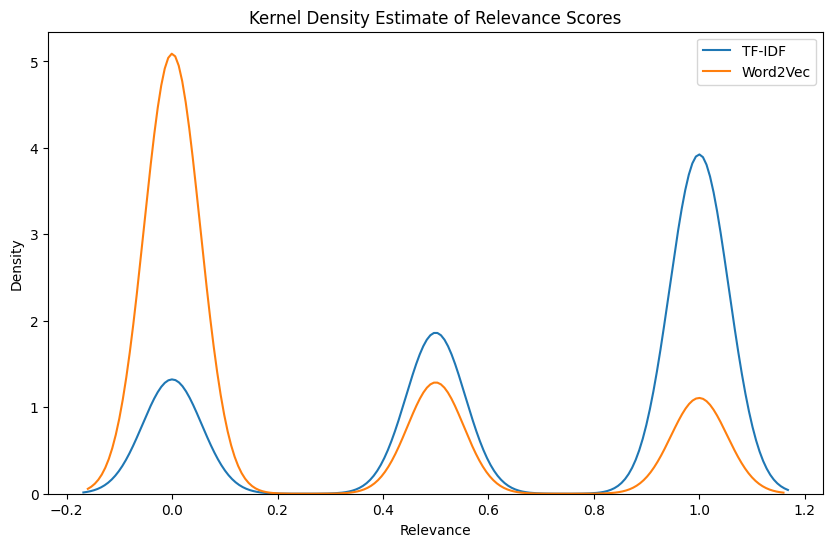

In [38]:
import pandas as pd  # Импортируем библиотеку для работы с табличными данными
import seaborn as sns  # Импортируем библиотеку для визуализации данных
import matplotlib.pyplot as plt  # Импортируем библиотеку для построения графиков

# Загрузка данных из CSV файла
df = pd.read_csv('annotation_relevance.csv')

# Замена запятых на точки в столбцах 'relevance_tfidf' и 'relevance_word2vec'
df['relevance_tfidf'] = df['relevance_tfidf'].str.replace(',', '.')
df['relevance_word2vec'] = df['relevance_word2vec'].str.replace(',', '.')

# Преобразование данных в числовой формат
df['relevance_tfidf'] = pd.to_numeric(df['relevance_tfidf'], errors='coerce')  # Преобразуем значения в числовой формат, некорректные значения заменяем на NaN
df['relevance_word2vec'] = pd.to_numeric(df['relevance_word2vec'], errors='coerce')  # Преобразуем значения в числовой формат, некорректные значения заменяем на NaN

# Проверка уникальных значений в данных
print("Уникальные значения для TF-IDF:", df['relevance_tfidf'].unique())  # Выводим уникальные значения для TF-IDF
print("Уникальные значения для Word2Vec:", df['relevance_word2vec'].unique())  # Выводим уникальные значения для Word2Vec

# Построение KDE (Kernel Density Estimate) для оценок релевантности TF-IDF и Word2Vec
plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
sns.kdeplot(df['relevance_tfidf'].dropna(), bw_adjust=0.5, label='TF-IDF')  # Строим KDE для TF-IDF, убирая NaN значения, устанавливаем сглаживание
sns.kdeplot(df['relevance_word2vec'].dropna(), bw_adjust=0.5, label='Word2Vec')  # Строим KDE для Word2Vec, убирая NaN значения, устанавливаем сглаживание

# Настройка графика
plt.xlabel('Relevance')  # Устанавливаем метку для оси X
plt.ylabel('Density')  # Устанавливаем метку для оси Y
plt.title('Kernel Density Estimate of Relevance Scores')  # Устанавливаем заголовок графика
plt.legend()  # Добавляем легенду для графика
plt.show()  # Отображаем график


RMSE for Word2Vec: 0.5687595375671899
RMSE for TF-IDF: 0.39783511801017457
MAE for Word2Vec: 0.5191864478588104
MAE for TF-IDF: 0.34932939966130044
MAPE for Word2Vec: 0.3347732754424214
MAPE for TF-IDF: 0.33401793026116366
R² for Word2Vec: -1.3743240918766606
R² for TF-IDF: -0.048087762627686104


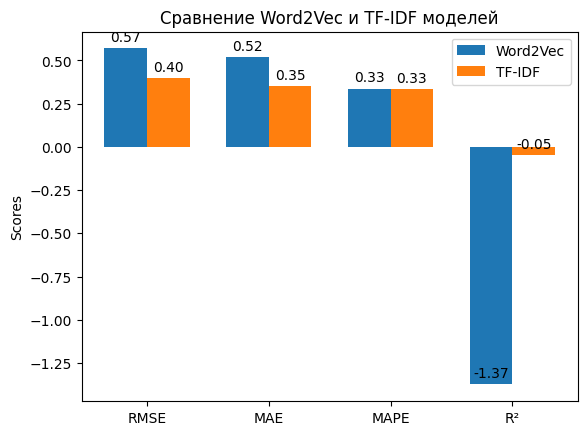

In [42]:
import numpy as np  # Импортируем библиотеку для работы с массивами и математическими функциями
import pandas as pd  # Импортируем библиотеку для работы с табличными данными
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Импортируем функции для расчета метрик
import matplotlib.pyplot as plt  # Импортируем библиотеку для построения графиков

# Загрузка данных из CSV файла
df = pd.read_csv('annotation_relevance.csv')

# Функция для замены запятой на точку
def replace_comma(value):
    if isinstance(value, str):  # Если значение является строкой
        return value.replace(',', '.')  # Заменяем запятые на точки
    return value  # Возвращаем значение без изменений, если оно не строка

# Применение функции к колонкам
df['predicted_relevance_tfidf'] = df['predicted_relevance_tfidf'].apply(replace_comma).astype(float)
df['relevance_tfidf'] = df['relevance_tfidf'].apply(replace_comma).astype(float)
df['predicted_relevance_word2vec'] = df['predicted_relevance_word2vec'].apply(replace_comma).astype(float)
df['relevance_word2vec'] = df['relevance_word2vec'].apply(replace_comma).astype(float)

# Создание списка реальных оценок и предсказанных оценок для Word2Vec
actual_relevance_word2vec = df['relevance_word2vec'].tolist()  # Сохраняем реальные оценки в список
predicted_relevance_word2vec = df['predicted_relevance_word2vec'].tolist()  # Сохраняем предсказанные оценки в список

# Создание списка реальных оценок и предсказанных оценок для TF-IDF
actual_relevance_tfidf = df['relevance_tfidf'].tolist()  # Сохраняем реальные оценки в список
predicted_relevance_tfidf = df['predicted_relevance_tfidf'].tolist()  # Сохраняем предсказанные оценки в список

# RMSE для модели Word2Vec
rmse_word2vec = mean_squared_error(actual_relevance_word2vec, predicted_relevance_word2vec, squared=False)  # Вычисляем RMSE
print(f"RMSE for Word2Vec: {rmse_word2vec}")

# RMSE для модели TF-IDF
rmse_tfidf = mean_squared_error(actual_relevance_tfidf, predicted_relevance_tfidf, squared=False)  # Вычисляем RMSE
print(f"RMSE for TF-IDF: {rmse_tfidf}")

# MAE для модели Word2Vec
mae_word2vec = mean_absolute_error(actual_relevance_word2vec, predicted_relevance_word2vec)  # Вычисляем MAE
print(f"MAE for Word2Vec: {mae_word2vec}")

# MAE для модели TF-IDF
mae_tfidf = mean_absolute_error(actual_relevance_tfidf, predicted_relevance_tfidf)  # Вычисляем MAE
print(f"MAE for TF-IDF: {mae_tfidf}")

# Функция для расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0  # Исключаем нулевые значения из y_true
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true))  # Вычисляем MAPE

# MAPE для модели Word2Vec
mape_word2vec = mean_absolute_percentage_error(actual_relevance_word2vec, predicted_relevance_word2vec)
print(f"MAPE for Word2Vec: {mape_word2vec}")

# MAPE для модели TF-IDF
mape_tfidf = mean_absolute_percentage_error(actual_relevance_tfidf, predicted_relevance_tfidf)
print(f"MAPE for TF-IDF: {mape_tfidf}")

# R² для модели Word2Vec
r2_word2vec = r2_score(actual_relevance_word2vec, predicted_relevance_word2vec)  # Вычисляем R²
print(f"R² for Word2Vec: {r2_word2vec}")

# R² для модели TF-IDF
r2_tfidf = r2_score(actual_relevance_tfidf, predicted_relevance_tfidf)  # Вычисляем R²
print(f"R² for TF-IDF: {r2_tfidf}")

# Построение графика сравнения метрик
metrics = ['RMSE', 'MAE', 'MAPE', 'R²']  # Названия метрик
word2vec_scores = [rmse_word2vec, mae_word2vec, mape_word2vec, r2_word2vec]  # Оценки метрик для Word2Vec
tfidf_scores = [rmse_tfidf, mae_tfidf, mape_tfidf, r2_tfidf]  # Оценки метрик для TF-IDF

x = np.arange(len(metrics))  # Создаем массив для оси X
width = 0.35  # Устанавливаем ширину столбцов

fig, ax = plt.subplots()  # Создаем фигуру и оси для графика
rects1 = ax.bar(x - width/2, word2vec_scores, width, label='Word2Vec')  # Столбцы для Word2Vec
rects2 = ax.bar(x + width/2, tfidf_scores, width, label='TF-IDF')  # Столбцы для TF-IDF

# Настройка осей и заголовка графика
ax.set_ylabel('Scores')  # Устанавливаем метку для оси Y
ax.set_title('Сравнение Word2Vec и TF-IDF моделей')  # Устанавливаем заголовок графика
ax.set_xticks(x)  # Устанавливаем метки для оси X
ax.set_xticklabels(metrics)  # Устанавливаем метки для оси X
ax.legend()  # Добавляем легенду

# Функция для отображения значений на графике
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()  # Получаем высоту столбца
        ax.annotate(f'{height:.2f}',  # Добавляем текст
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # Координаты текста
                    xytext=(0, 3),  # Смещение текста
                    textcoords="offset points",  # Используем относительные координаты
                    ha='center', va='bottom')  # Выравнивание текста

autolabel(rects1)  # Добавляем значения для Word2Vec
autolabel(rects2)  # Добавляем значения для TF-IDF

plt.show()  # Отображаем график
